In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.linear_solver import pywraplp
import random
import os

DIVERSITY_UTILITY = float(os.environ.get('DIVERSITY_UTILITY'))
FRAC_ADMIT = float(os.environ.get('FRAC_ADMIT'))

In [2]:

###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test.csv')
df['key'] = df['R'].astype(str) + "_"  + df['T'].astype(str)

###
## Estimate E[Y(1)|T, A]
###

df_train = pd.read_csv('./df_train.csv')
df_stratum_utility = df_train[['R','T','Y']].groupby(['R','T']).mean().reset_index()
df_stratum_utility['stratum_utility'] = (df_stratum_utility['Y'] + DIVERSITY_UTILITY * df_stratum_utility['R']).round(2)
df_stratum_utility['key'] = df_stratum_utility['R'].astype(str) + "_" + df_stratum_utility['T'].astype(str)

df = df.merge(df_stratum_utility[['stratum_utility','key']], on='key')
df['ml_outcomes'] = df['stratum_utility']

In [3]:
len(df)

999999

<AxesSubplot:>

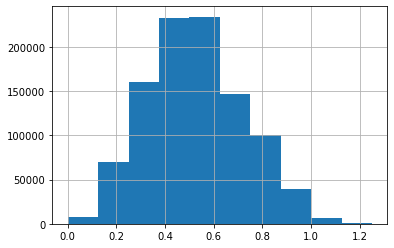

In [4]:
df['ml_outcomes'].hist()

In [5]:
##
# R = race, T = test score, ml_outcomes = expected utility from admitting, 
# ml_outcomes_{} counterfactual utility given race 
##

df[['R','T','ml_outcomes','T_minority','T_majority','Y']].sort_values(by='ml_outcomes')



,R,T,ml_outcomes,T_minority,T_majority,Y
999835,0,11,0.00,11,11,0
999838,0,11,0.00,7,11,0
999837,0,11,0.00,8,11,0
999836,0,11,0.00,11,11,0
999886,0,12,0.02,11,12,0
...,...,...,...,...,...,...
999913,1,98,1.25,98,115,1
999914,1,98,1.25,98,115,1
999925,1,109,1.25,109,126,1
998845,1,97,1.25,97,112,1


In [6]:
###
## Get total utility from admitting people in a stratum 
###

df_ = df[['R','T','ml_outcomes']].groupby(['R','T']).sum().reset_index()

In [7]:
###
## Get number of people in each stratum
###

df_count = df[['R','T','ml_outcomes']].groupby(['R','T']).count().reset_index()
df_count.columns = ['R','T','Count']
df_count['N'] = df_count['Count']

In [8]:
###
## Get boards passage probability in each stratum
###

df_prob = df[['R','T','Y']].groupby(['R','T']).mean().reset_index()
df_prob.columns = ['R','T','ml_outcomes_prob']

#df_prob = df[['R','T','ml_outcomes_prob']]

In [9]:
###
## Merge summary tables to get one table with Race, Test Score, SUM(Utility), COUNT(applicants), E(Y(1)|X )
###

dff = df_.merge(df_count[['N']],left_index=True,right_index=True)
dff = dff.merge(df_prob[['ml_outcomes_prob']],left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False).reset_index().sort_values(by='index').reset_index()



In [10]:
# final info table
dff.sort_values(by='ml_outcomes_prob')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob
0,218,0,0,9,0.10,1,0.0
120,217,120,1,8,0.32,1,0.0
121,207,121,1,9,1.00,4,0.0
122,194,122,1,10,2.73,7,0.0
125,189,125,1,13,3.90,13,0.0
...,...,...,...,...,...,...,...
113,192,113,0,122,3.00,3,1.0
114,200,114,0,123,2.00,2,1.0
116,199,116,0,125,2.00,2,1.0
107,185,107,0,116,7.00,7,1.0


In [11]:
dff['Pr(X=X_j)'] = dff['N']/(dff['N']).sum()

In [12]:
dff[dff['R']==1].sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j)
119,215,119,1,7,0.50,2,0.0,0.000002
120,217,120,1,8,0.32,1,0.0,0.000001
121,207,121,1,9,1.00,4,0.0,0.000004
122,194,122,1,10,2.73,7,0.0,0.000007
123,214,123,1,11,0.52,2,0.5,0.000002
...,...,...,...,...,...,...,...,...
217,203,217,1,107,1.25,1,1.0,0.000001
218,204,218,1,109,1.25,1,1.0,0.000001
219,205,219,1,111,1.25,1,1.0,0.000001
220,212,220,1,113,0.92,1,1.0,0.000001


In [13]:
df_decisions = None
max_utility = -1.0

for C_y in np.linspace(0.0,1.0,101):
    dff['alpha_j'] = dff['Pr(X=X_j)']* (dff['ml_outcomes_prob'] - C_y)
    solver = pywraplp.Solver.CreateSolver('GLOP')

    
    applicant_stratum = []
    vars_cache = {}
    alpha_j = {}
    
    # Objective: Maximize the expected utility of the admitted students
    objective = solver.Objective()
    
    # For each stratum
    for ix, row in dff.iterrows():
        # probability of admission
        numvar = solver.NumVar(0.0, 1.0, str(ix))
        
        # store variable by index, and also by stratum R, T
        applicant_stratum.append(numvar)
        vars_cache[(row['R'],row['T'])] = numvar
        
        alpha_j[(row['R'],row['T'])] = row['alpha_j']
        
        # Benefit of admitting people is total utility in that stratum
        objective.SetCoefficient(applicant_stratum[ix], float(row['ml_outcomes']))
        
    objective.SetMaximization()

    # Constraint: At most K applicants
    K = int(len(df)*FRAC_ADMIT)
    admit_quota = solver.Constraint(0, K)
    
    # Total admits cannot exceed K 
    for ix, row in dff.iterrows():
        admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))
    
    
    sum_alpha = 0
    R = 1 
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_minority = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_minority.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )    
    
    sum_alpha = 0
    R = 0
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_majority = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_majority.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )
        
    status = solver.Solve()

    if status != 2:
        TOTAL_UTILITY = 0
        for ix, row in dff.iterrows():
            TOTAL_UTILITY += float(row['ml_outcomes'])* vars_cache[(row['R'],row['T'])].solution_value()
        print(C_y,TOTAL_UTILITY)
        
        if TOTAL_UTILITY > max_utility:
            row = []
            admit = []
        
            for i in applicant_stratum:
                row.append(int(str(i)))
                admit.append(i.solution_value())
            
            df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
            
            max_utility = TOTAL_UTILITY


0.44 148658.77640573794
0.45 146073.64251138366
0.46 143323.27562669845
0.47000000000000003 140412.8457978842
0.48 137279.52144158276
0.49 133909.64950645916
0.5 130255.9629560271
0.51 118933.38218049564
0.52 106446.23523554557


## Add CF Predictive Parity Constraints

In [14]:
max_utility

148658.77640573794

In [15]:
dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
49,0,49,0,58,11233.60,20060,0.565852,0.020060,-0.008709,49,0.0
50,1,50,0,59,11169.64,19258,0.576903,0.019258,-0.008148,50,0.0
48,2,48,0,57,11030.04,20426,0.548517,0.020426,-0.009222,48,0.0
47,3,47,0,56,10985.52,21126,0.524709,0.021126,-0.010041,47,0.0
51,4,51,0,60,10970.40,18284,0.601783,0.018284,-0.007281,51,0.0
...,...,...,...,...,...,...,...,...,...,...,...
120,217,120,1,8,0.32,1,0.000000,0.000001,-0.000001,120,1.0
0,218,0,0,9,0.10,1,0.000000,0.000001,-0.000001,0,0.0
1,219,1,0,10,0.08,1,0.000000,0.000001,-0.000001,1,0.0
3,220,3,0,12,0.08,4,0.000000,0.000004,-0.000004,3,0.0


In [16]:
xxx_ = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx_.sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
119,215,119,1,7,0.50,2,0.0,0.000002,-0.000002,119,1.0
120,217,120,1,8,0.32,1,0.0,0.000001,-0.000001,120,1.0
0,218,0,0,9,0.10,1,0.0,0.000001,-0.000001,0,0.0
121,207,121,1,9,1.00,4,0.0,0.000004,-0.000004,121,1.0
1,219,1,0,10,0.08,1,0.0,0.000001,-0.000001,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
114,200,114,0,123,2.00,2,1.0,0.000002,0.000000,114,1.0
115,209,115,0,124,1.00,1,0.0,0.000001,-0.000001,115,1.0
116,199,116,0,125,2.00,2,1.0,0.000002,0.000000,116,1.0
117,208,117,0,127,1.00,1,1.0,0.000001,0.000000,117,1.0


In [17]:
xxx = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
49,0,49,0,58,11233.60,20060,0.565852,0.020060,-0.008709,49,0.0
50,1,50,0,59,11169.64,19258,0.576903,0.019258,-0.008148,50,0.0
48,2,48,0,57,11030.04,20426,0.548517,0.020426,-0.009222,48,0.0
47,3,47,0,56,10985.52,21126,0.524709,0.021126,-0.010041,47,0.0
51,4,51,0,60,10970.40,18284,0.601783,0.018284,-0.007281,51,0.0
...,...,...,...,...,...,...,...,...,...,...,...
120,217,120,1,8,0.32,1,0.000000,0.000001,-0.000001,120,1.0
0,218,0,0,9,0.10,1,0.000000,0.000001,-0.000001,0,0.0
1,219,1,0,10,0.08,1,0.000000,0.000001,-0.000001,1,0.0
3,220,3,0,12,0.08,4,0.000000,0.000004,-0.000004,3,0.0


In [18]:
len(xxx_)

222

In [19]:
xxx

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
49,0,49,0,58,11233.60,20060,0.565852,0.020060,-0.008709,49,0.0
50,1,50,0,59,11169.64,19258,0.576903,0.019258,-0.008148,50,0.0
48,2,48,0,57,11030.04,20426,0.548517,0.020426,-0.009222,48,0.0
47,3,47,0,56,10985.52,21126,0.524709,0.021126,-0.010041,47,0.0
51,4,51,0,60,10970.40,18284,0.601783,0.018284,-0.007281,51,0.0
...,...,...,...,...,...,...,...,...,...,...,...
120,217,120,1,8,0.32,1,0.000000,0.000001,-0.000001,120,1.0
0,218,0,0,9,0.10,1,0.000000,0.000001,-0.000001,0,0.0
1,219,1,0,10,0.08,1,0.000000,0.000001,-0.000001,1,0.0
3,220,3,0,12,0.08,4,0.000000,0.000004,-0.000004,3,0.0


In [20]:
(xxx['ml_outcomes']*xxx['decision']).sum()

148658.77640573797

In [21]:
def maxMLOutcomes(frac_minority=0.01):
    minority_admits = int(K*frac_minority)
    majority_admits = int(K*(1-frac_minority))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=minority_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=majority_admits)
    
    return b['Y'].sum() + w['Y'].sum()    

In [22]:
def maxMLOutcomesminority(frac_minority=0.01):
    minority_admits = int(K*frac_minority)
    majority_admits = int(K*(1-frac_minority))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=minority_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=majority_admits)
    
    return b['Y'].sum()   

In [23]:
df['key'] = df['R'].astype(str)+'_'+df['T'].astype(str)
xxx['key'] = xxx['R'].astype(str)+'_'+xxx['T'].astype(str)

In [24]:
len(xxx)

222

In [25]:
admit_decisions = df.merge(xxx,how='left',on='key')
admit_decisions['decision_random'] = pd.Series([random.random() for x in range(0,len(admit_decisions))]) < FRAC_ADMIT


FRAC_minority_POLICY = (admit_decisions['R_y'] * admit_decisions['decision']).sum()/admit_decisions['decision'].sum()
SUM_BP_POLICY = ( admit_decisions['Y'] * admit_decisions['decision']).sum()

FRAC_RANDOM_POLICY = (admit_decisions['R_y'] * admit_decisions['decision_random']).sum()/admit_decisions['decision_random'].sum()
SUM_BP_RAND_POLICY = ( admit_decisions['Y'] * admit_decisions['decision_random']).sum()


In [26]:
str(FRAC_minority_POLICY),str(SUM_BP_POLICY)

('0.5758883998253692', '112677.00000000003')

In [27]:
file = open('./lp_results.csv','a')
file.write('{}\t{}\t{}\n'.format('Counterfactual Pred. Parity',str(FRAC_minority_POLICY),str(SUM_BP_POLICY)))
file.close()


In [28]:
(xxx['N']*xxx['decision']).sum()/len(df)

0.24999924999925005

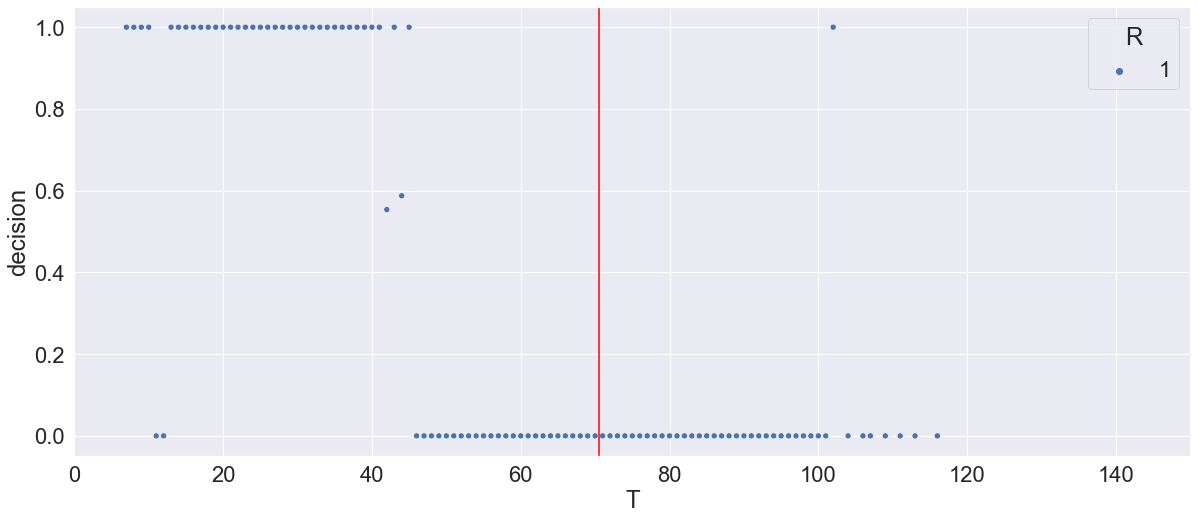

In [29]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==1])
g.set(xlim=(0, 150))
plt.axvline(70.5, 0,1,color='red')


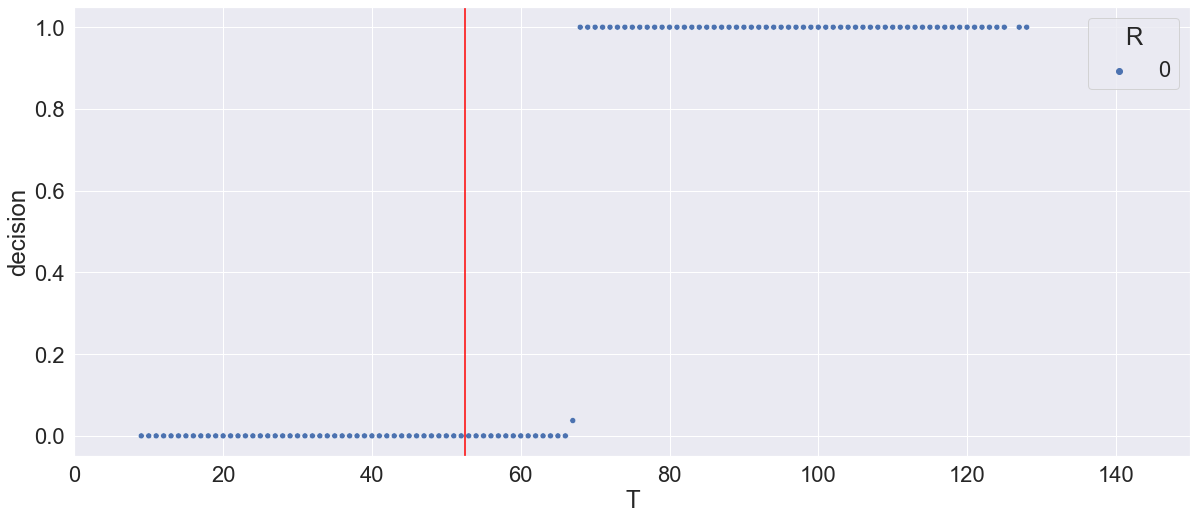

In [30]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==0])
g.set(xlim=(0, 150))
plt.axvline(52.5, 0,1,color='red')



In [31]:
admit_decisions[admit_decisions['decision']==0][['R_x','Y']].groupby(['R_x']).mean()

,Y
R_x,
0,0.434171
1,0.452217


In [32]:
str(FRAC_minority_POLICY),str(SUM_BP_POLICY)

('0.5758883998253692', '112677.00000000003')

In [33]:
SUM_BP_POLICY/(FRAC_ADMIT*len(df))

0.45070845070845084

In [34]:
str(FRAC_minority_POLICY),str(SUM_BP_POLICY)

('0.5758883998253692', '112677.00000000003')

In [35]:
admit_decisions[admit_decisions['decision']==1]['Y'].mean()

0.46288872769230116

In [36]:
(admit_decisions['decision'] * admit_decisions['ml_outcomes_x']).sum()

148658.77640573797

In [37]:
(admit_decisions['decision'] * admit_decisions['Y']).sum()

112677.00000000003

In [38]:
admit_decisions[admit_decisions['decision']==1]['Y'].sum()

109120

In [39]:
(admit_decisions['decision'] * admit_decisions['Y']).sum()/(len(admit_decisions)*FRAC_ADMIT)

0.45070845070845084

In [40]:
(admit_decisions['decision'].sum())

249999.00000000006

In [41]:
admit_decisions['rand'] = pd.Series([random.random() for x in range(0,len(admit_decisions))])
admit_decisions['dec_binary'] = admit_decisions['rand'] < admit_decisions['decision']


In [42]:
admit_decisions[admit_decisions['dec_binary']==0][['R_x','Y']].groupby(['R_x']).mean()

,Y
R_x,
0,0.440043
1,0.439618


In [43]:
admit_decisions['R_x'].value_counts()

0    669901
1    330098
Name: R_x, dtype: int64